In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),           
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

Using device: mps


In [ ]:
full_dataset = datasets.ImageFolder(root="valid", transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except (OSError, IOError):
            return self.__getitem__((index + 1) % len(self.samples))  

test_dataset = SafeImageFolder(root="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset split: {train_size} train, {val_size} validation, {len(test_dataset)} test samples.")

Dataset split: 5040 train, 1260 validation, 6300 test samples.


In [ ]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
num_epochs = 15
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []


start_time = time.time() 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0 

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

end_time = time.time()
print(f"\n Training Completed in {end_time - start_time:.2f} seconds.")


Epoch 1/15 - Train Loss: 0.1746, Train Acc: 94.64% - Val Loss: 0.0654, Val Acc: 97.86% - Test Loss: 0.0567, Test Acc: 98.11%
Epoch 2/15 - Train Loss: 0.0558, Train Acc: 98.29% - Val Loss: 0.0562, Val Acc: 98.10% - Test Loss: 0.0423, Test Acc: 98.48%
Epoch 3/15 - Train Loss: 0.0333, Train Acc: 98.99% - Val Loss: 0.0542, Val Acc: 98.10% - Test Loss: 0.0411, Test Acc: 98.75%
Epoch 4/15 - Train Loss: 0.0206, Train Acc: 99.38% - Val Loss: 0.0552, Val Acc: 98.25% - Test Loss: 0.0387, Test Acc: 98.56%
Epoch 5/15 - Train Loss: 0.0111, Train Acc: 99.78% - Val Loss: 0.0587, Val Acc: 98.49% - Test Loss: 0.0361, Test Acc: 98.76%
Epoch 6/15 - Train Loss: 0.0083, Train Acc: 99.80% - Val Loss: 0.0690, Val Acc: 98.49% - Test Loss: 0.0411, Test Acc: 98.76%
Epoch 7/15 - Train Loss: 0.0067, Train Acc: 99.80% - Val Loss: 0.0734, Val Acc: 98.41% - Test Loss: 0.0408, Test Acc: 98.70%
Epoch 8/15 - Train Loss: 0.0035, Train Acc: 99.94% - Val Loss: 0.0780, Val Acc: 98.10% - Test Loss: 0.0442, Test Acc: 98.75%


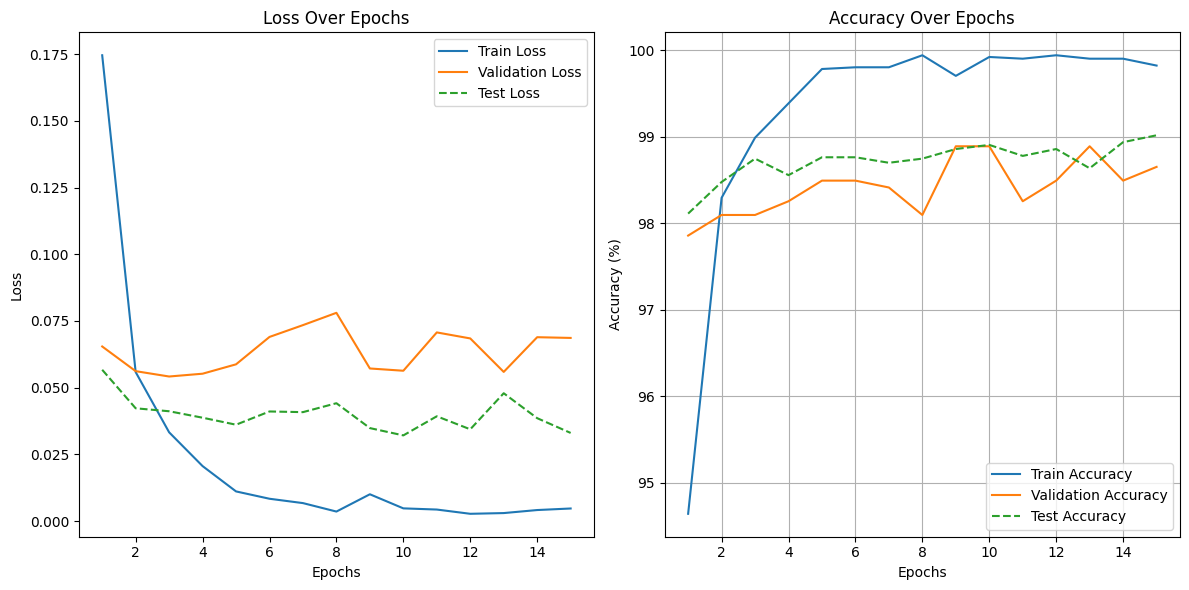

In [14]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.plot(epochs, test_losses, label="Test Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", linestyle="dashed")
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
torch.save(model.state_dict(), "efficientnet_b2_wildfire.pth")
print("Model saved as efficientnet_b2_wildfire.pth")

Model saved as efficientnet_b2_wildfire.pth
